In [1]:
from evaluate_decoder import *

from quantum_error_correction_code import SurfaceCode
from neural_network import CNNDual, CNNDecoder, load_params

from jax import random
import jax.numpy as jnp

key = random.key(42)

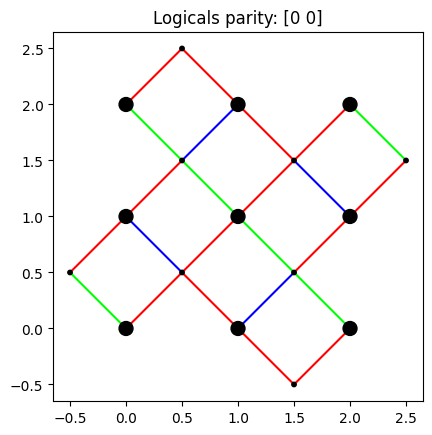

In [2]:
code = SurfaceCode(3)

# deformation, key = code.random_deformation(key, allowed_deformations=jnp.array([0]))
deformation = jnp.array([2,0,2,3,2,3,2,0,2])

parity_info = code.deformation_parity_info(deformation)

code.show(parity_info)

In [3]:
batch_size = 32
error_probs = jnp.array([1E-5, 1E-5, 1E-2])

# Test data function

In [4]:
syndromes, logicals = data_batch(
    key,
    code,
    batch_size,
    parity_info,
    error_probs,
    as_images=True
)
syndromes.shape

(32, 4, 4)

# Test evaluation function on the PML decoder

In [5]:
evaluate_pml_decoder(
    key,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs
)

(Array(2.6400001e-05, dtype=float32),
 Array([[9145120,      11,       5,      76],
        [     15,  194428,      54,       2],
        [     14,      75,  194786,       5],
        [      0,       4,       3,  465402]], dtype=int32))

In [6]:
evaluate_pml_decoder(
    key,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs,
    exact=True
)

(Array(2.5510788e-05, dtype=float32),
 Array([[9.1449153e-01, 5.9835588e-07, 5.9743326e-07, 7.7841241e-06],
        [1.1483708e-06, 1.9465834e-02, 5.8745463e-06, 4.5036592e-07],
        [1.1502543e-06, 5.8764472e-06, 1.9465841e-02, 4.5040474e-07],
        [2.2048712e-07, 5.8858768e-07, 5.8950957e-07, 4.6552382e-02]],      dtype=float32))

# Test evaluation function on the MWPM decoder

In [6]:
evaluate_mwpm_decoder(
    key,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs
)

(Array(0.0017514, dtype=float32),
 Array([[9135604,      79,      75,      64],
        [   4747,  190640,      43,      54],
        [   4763,      60,  190949,      74],
        [     35,    3739,    3781,  465293]], dtype=int32))

# Test evaluation function on a mCNN decoder

In [7]:
settings, model_params = load_params("../data/CNN-G-3.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(1, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

In [8]:
evaluate_mcnn_decoder(
    key,
    decoder_model,
    model_params,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs,
)

(Array(0.0001556, dtype=float32),
 Array([[9146704,     444,     268,     114],
        [     62,  193539,      65,     214],
        [     78,     112,  194086,     128],
        [     10,      40,      21,  464115]], dtype=int32))

# Test evaluation function on a CNN decoder

In [12]:
settings, model_params = load_params("../data/CNN-3-202323202.json")
# settings, model_params = load_params("../data/CNN-3-000000000.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDecoder(
    input_shape = (1, L+1, L+1),
    conv_layers = [tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS"]],
    fc_layers = [int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN': [(1, 4, 4), (8, 3, 3), (8, 2, 2)], 'MLP': [32, 50, 2]}

In [13]:
evaluate_cnn_decoder(
    key,
    decoder_model,
    model_params,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs,
)

(Array(2.9599998e-05, dtype=float32),
 Array([[9146810,      11,      10,      73],
        [     28,  194042,      56,       6],
        [     16,      75,  194362,       2],
        [      0,       7,      12,  464490]], dtype=int32))